В этой части получаем графики зависимости фазы сгенерированной от отклонения между полученной фазой и сгенерированной. Это делается для того чтобы определить насколько точно работают методы во всём возможном диапазоне. Графики строятся для разных частот сигнала. Таким образом получается оценить точность методов для разных фаз и частот сгенерированных сигналов

In [1]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [2]:
def get_phase_hilbert(time, sig1, sig2, f_peak=440e3):
    phase1 = np.unwrap(np.angle(signal.hilbert(sig1)))
    phase2 = np.unwrap(np.angle(signal.hilbert(sig2)))
    
    phase_diff = np.rad2deg(phase2 - phase1)
    phase_diff = np.rad2deg(np.unwrap(np.angle(signal.hilbert(sig2)) - np.angle(signal.hilbert(sig1))))
    phase_diff = (phase_diff + 180) % 360 - 180 
    return time, phase_diff

In [3]:
def variate_phase(F, *phase_methods):
    phases_arrays = []
    phase_diff_arrays = []

    for phase_method in phase_methods:
        phases = []
        phase_diff = []
        for phase in range(1, 180, 1):
            duration = 100e-6
            fs = F * 40

            t = np.linspace(0, duration, int(duration * fs))
            U = md.generate_sin(t, F, 2)
            I = md.generate_sin(t, F, 2, phase)

            # Вызов метода напрямую
            time, phase_d = phase_method(t, U, I, F)

            phase_kde = md.get_kde_mode(phase_d)

            phases.append(phase)
            phase_diff.append(abs(phase_kde - phase))

        phases_arrays.append(phases)
        phase_diff_arrays.append(phase_diff)

    return phases_arrays, phase_diff_arrays

In [4]:
def plot_for_one_F(phase_methods,phases_arrays,phase_diff_arrays, title=""):
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 1)
    front = 12

    ax1 = fig.add_subplot(gs[0, 0])
    for i, method in enumerate(phase_methods):
        label_name = method.__name__.replace("get_phase_", "")
        ax1.plot(
            phases_arrays[i],
            np.abs(phase_diff_arrays[i]),
            label=label_name,
            linewidth=2
        )

    ax1.set_xlabel('Phase shift, °', fontsize=front)
    ax1.set_ylabel('Phase measurement deviation, °', fontsize=front)
    ax1.tick_params(axis='both', labelsize=front)
    ax1.grid(True)
    ax1.legend(fontsize=10)

    ax1.set_yscale('log')

    ax1.set_title(title, fontsize=front + 2)
    plt.tight_layout()
    plt.show()

In [5]:
phase_methods = [
    md.get_phase_maxpoint_diff,
    md.get_phase_hilbert,
    md.get_phase_FFT,
    md.get_phase_lockin,
    md.get_phase_xcorr2
]


In [6]:
F=444.4e3
phases_arrays, phase_diff_arrays = variate_phase(F, *phase_methods)

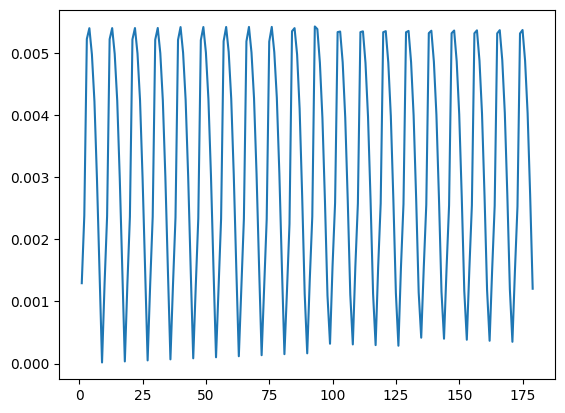

In [7]:
plt.plot(phases_arrays[0], phase_diff_arrays[0])

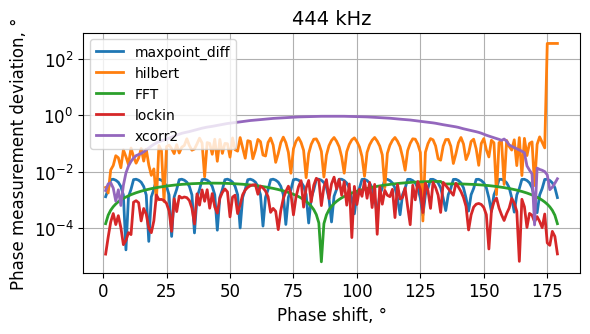

In [8]:
plot_for_one_F(phase_methods,phases_arrays, phase_diff_arrays,str(int(F/1000))+" kHz" )

In [9]:
from functools import reduce

summ_error_full = reduce(np.add, phase_diff_arrays)

summ_error_no_xcor = reduce(np.add, phase_diff_arrays[:-1])

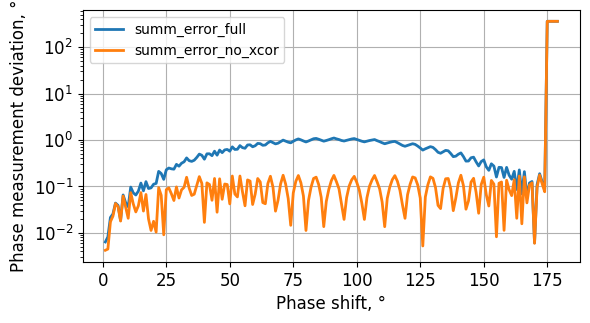

In [10]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 1)
front = 12
ax1 = fig.add_subplot(gs[0, 0])


ax1.plot(
    phases_arrays[0],
    np.abs(summ_error_full),
    label="summ_error_full",
    linewidth=2
)
ax1.plot(
    phases_arrays[0],
    np.abs(summ_error_no_xcor),
    label="summ_error_no_xcor",
    linewidth=2
)

ax1.set_xlabel('Phase shift, °', fontsize=front)
ax1.set_ylabel('Phase measurement deviation, °', fontsize=front)
ax1.tick_params(axis='both', labelsize=front)
ax1.grid(True)
ax1.legend(fontsize=10)
ax1.set_yscale('log')
plt.tight_layout()
plt.show()

In [11]:
F_range=[]
KDE_range=[]

for F in range (int(300e3),int(500e3),int(50e3)):
    KDE_methods=[]
    F_range.append(F)
    phases,phases_diff=variate_phase(F,*phase_methods)

    for i in range(0,len(phases_diff),1):
        KDE_methods.append(md.get_kde_mode(phases_diff[i]))
    KDE_range.append(KDE_methods)
    print(KDE_methods)



[np.float64(0.004153661584780519), np.float64(0.0004461784803911289), np.float64(0.003286707211576944), np.float64(0.0004832434492951874), np.float64(0.09060397355892097)]
[np.float64(0.004215511592081571), np.float64(0.0004543327129046165), np.float64(0.0028342659323873053), np.float64(0.000427651319002043), np.float64(0.09008133659131055)]
[np.float64(0.004264396156021608), np.float64(0.00045666909289895794), np.float64(0.0025004691161577674), np.float64(0.00039238313659372515), np.float64(0.08950773838960388)]
[np.float64(0.00430253210278105), np.float64(0.0004538603126255373), np.float64(0.0022370012715970393), np.float64(0.00028465123797735654), np.float64(0.09025000146930083)]


ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

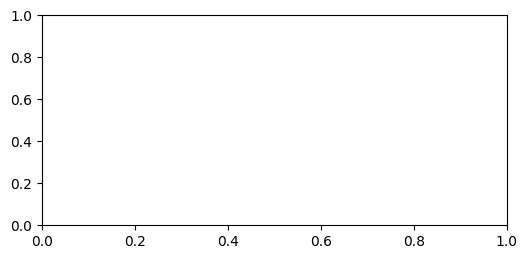

In [14]:
plot_for_one_F(phase_methods,F_range,KDE_range)